In [ ]:
# use data s&p close preice 1990-2020 daily
# 252 trading days a year


## 1. simple time series analysis

In [7]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [13]:
#load data
data = pd.read_csv('shanghai_index_1990_12_19_to_2020_03_12.csv',usecols=['Timestamp','Price'])

In [16]:
data = pd.read_csv('shanghai_index_1990_12_19_to_2020_03_12.csv', usecols=['Timestamp', 'Price'])
data.Timestamp = pd.to_datetime(data.Timestamp)
data = data.set_index('Timestamp')
data['Price'] = data['Price'].apply(pd.to_numeric, errors='ignore')

In [17]:
# impute missing data
data.Price.interpolate(inplace=True)

In [18]:
# return with trend, seasonal, and residual
result = sm.tsa.seasonal_decompose(data.Price, freq=288)


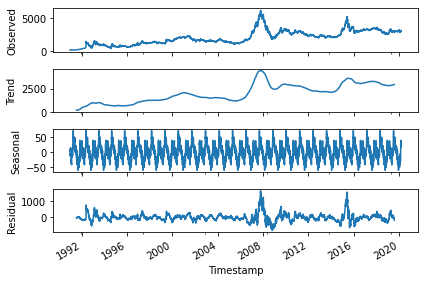

In [20]:
result.plot()
plt.show()

## 2. ARMA

In [23]:
import numpy as np
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

In [25]:
warnings.filterwarnings('ignore')

In [27]:
# load data
df = pd.read_csv('./shanghai_index_1990_12_19_to_2020_03_12.csv')
df = df[['Timestamp','Price']]


In [30]:
# use time as df reference
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp

In [32]:
# explore the data
print(df.head())

            Timestamp   Price
Timestamp                    
1990-12-19 1990-12-19   99.98
1990-12-20 1990-12-20  104.39
1990-12-21 1990-12-21  109.13
1990-12-24 1990-12-24  114.55
1990-12-25 1990-12-25  120.25


In [41]:
df_month = df.resample('M').mean()
df_q = df.resample('Q-DEC').mean()
df_year = df.resample('A-dec').mean()
print(df_month)

                  Price
Timestamp              
1990-12-31   116.990000
1991-01-31   132.628182
1991-02-28   131.887778
1991-03-31   126.011429
1991-04-30   118.426818
...                 ...
2019-11-30  2923.774700
2019-12-31  2962.063709
2020-01-31  3078.654681
2020-02-29  2927.513035
2020-03-31  2990.415289

[352 rows x 1 columns]


In [37]:
print(df_q)

                  Price
Timestamp              
1990-12-31   116.990000
1991-03-31   130.131803
1991-06-30   117.945625
1991-09-30   160.548030
1991-12-31   240.092656
...                 ...
2019-03-31  2792.941622
2019-06-30  3010.354852
2019-09-30  2923.130869
2019-12-31  2946.748434
2020-03-31  2993.832738

[118 rows x 1 columns]


In [43]:
print(df_year)

                  Price
Timestamp              
1990-12-31   116.990000
1991-12-31   162.543765
1992-12-31   668.515608
1993-12-31  1013.247004
1994-12-31   674.123214
1995-12-31   657.789203
1996-12-31   764.639478
1997-12-31  1175.584881
1998-12-31  1261.037159
1999-12-31  1377.330674
2000-12-31  1881.996556
2001-12-31  1956.159812
2002-12-31  1567.231135
2003-12-31  1467.738058
2004-12-31  1482.854667
2005-12-31  1153.550678
2006-12-31  1629.934141
2007-12-31  4237.692008
2008-12-31  3031.825398
2009-12-31  2765.430332
2010-12-31  2830.994508
2011-12-31  2666.891836
2012-12-31  2219.135486
2013-12-31  2191.699298
2014-12-31  2238.214951
2015-12-31  3721.552045
2016-12-31  3003.683787
2017-12-31  3249.687147
2018-12-31  2943.151610
2019-12-31  2919.537157
2020-12-31  2993.832738


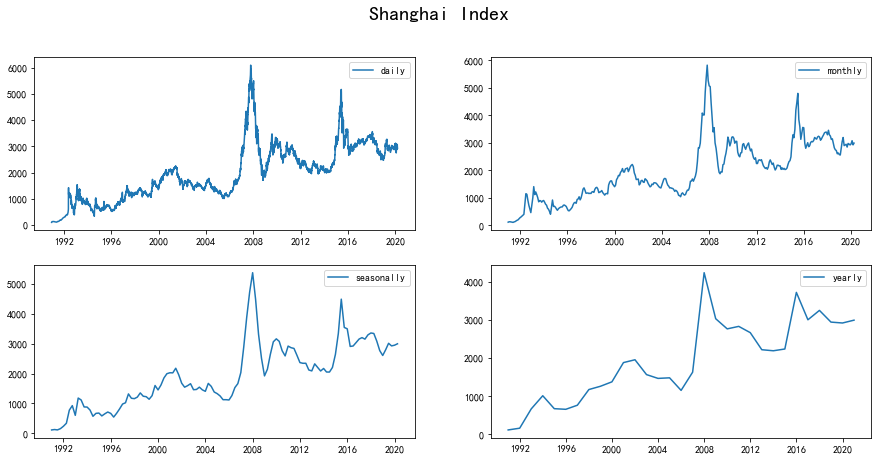

In [46]:
# show trend
fig = plt.figure(figsize=[15,7])
plt.rcParams['font.sans-serif']=['SimHei'] # font in Chiese
plt.suptitle('Shanghai Index',fontsize=20)
plt.subplot(221)
plt.plot(df.Price,'-',label='daily')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price,'-',label='monthly')
plt.legend()
plt.subplot(223)
plt.plot(df_q.Price,'-',label='seasonally')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price,'-',label='yearly')
plt.legend()
plt.show()


In [50]:
# set ps q parameter ranges
ps = range(0,3)
qs = range(0,3)
parameters = product(ps,qs)
parameters_list = list(parameters)
# seeking for optimal ARMA parameters (smallest best_aic)
results=[]
best_aic =float("inf")  # infinite
for param in parameters_list:
    try:
        model = ARMA(df_month.Price, order=(param[0],param[1])).fit()
    except ValueError:
        print('wrong parameters:',param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param =param
    results.append([param,model.aic])
# print the best results
print('Optimal model:', best_model.summary())



wrong parameters: (0, 2)
Optimal model:                               ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  352
Model:                     ARMA(2, 2)   Log Likelihood               -2290.943
Method:                       css-mle   S.D. of innovations            161.347
Date:                Sun, 06 Sep 2020   AIC                           4593.887
Time:                        14:45:50   BIC                           4617.069
Sample:                    12-31-1990   HQIC                          4603.112
                         - 03-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1884.9435    497.811      3.786      0.000     909.251    2860.636
ar.L1.Price     0.4820      0.129      3.726      0.000       0.228       0.735
ar.L2.Pr

In [58]:
# set future_month and date_list for forecasting
df_month2 = df_month[['Price']]
future_month =12
last_month =pd.to_datetime(df_month2.index[len(df_month2)-1])
print(last_month)

2020-03-31 00:00:00


In [59]:
date_list = []
for i in range(future_month):
    # calculate how many days in the next month
    year = last_month.year
    month = last_month.month
    if month ==12:
        month =1
        year =year+1
    else:
        month=month+1
    next_month_days = calendar.monthrange(year,month)[1]
    print(next_month_days)
    last_month =last_month +timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=',date_list)
    

30
31
30
31
31
30
31
30
31
31
28
31
date_list= [Timestamp('2020-04-30 00:00:00', freq='M'), Timestamp('2020-05-31 00:00:00', freq='M'), Timestamp('2020-06-30 00:00:00', freq='M'), Timestamp('2020-07-31 00:00:00', freq='M'), Timestamp('2020-08-31 00:00:00', freq='M'), Timestamp('2020-09-30 00:00:00', freq='M'), Timestamp('2020-10-31 00:00:00', freq='M'), Timestamp('2020-11-30 00:00:00', freq='M'), Timestamp('2020-12-31 00:00:00', freq='M'), Timestamp('2021-01-31 00:00:00', freq='M'), Timestamp('2021-02-28 00:00:00', freq='M'), Timestamp('2021-03-31 00:00:00', freq='M')]


                 Price     forecast
1990-12-31  116.990000          NaN
1991-01-31  132.628182   138.782687
1991-02-28  131.887778   167.300296
1991-03-31  126.011429   161.380253
1991-04-30  118.426818   147.419417
...                ...          ...
2020-11-30         NaN  2840.993603
2020-12-31         NaN  2818.381494
2021-01-31         NaN  2796.773929
2021-02-28         NaN  2775.434076
2021-03-31         NaN  2754.708634

[376 rows x 2 columns]


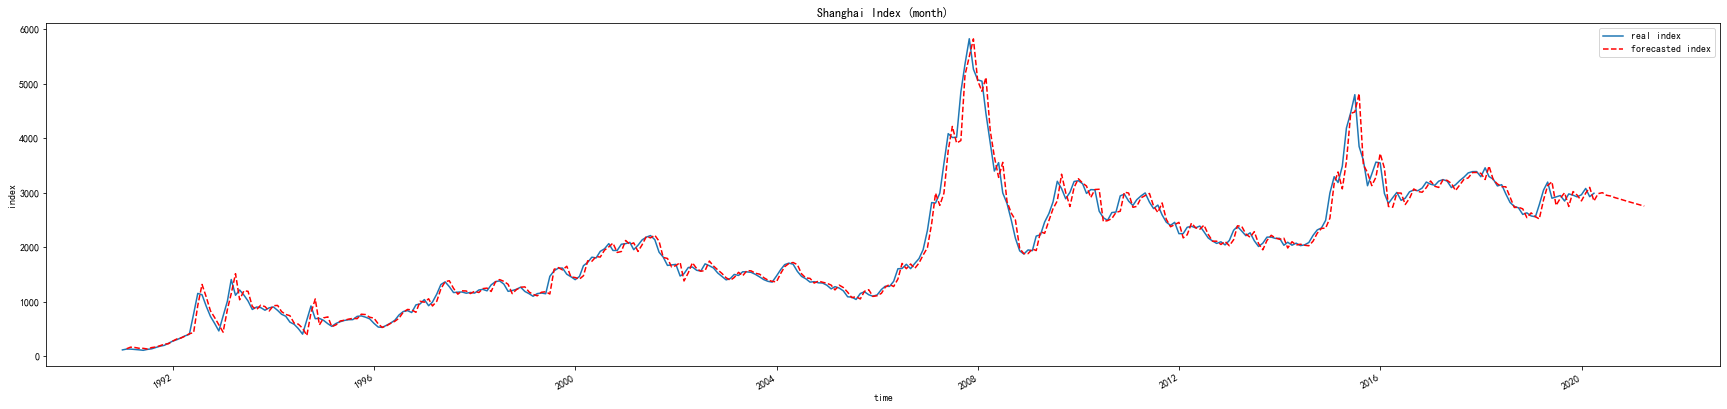

In [61]:
# edit the forecasting period
future = pd.DataFrame(index=date_list,columns=df_month.columns)
df_month2 =pd.concat([df_month2,future])
df_month2['forecast'] =best_model.predict(start=0,end=len(df_month2))

# the first element is wrong, set as NaN
df_month2['forecast'][0] =np.NaN
print(df_month2)

# show predictions
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='real index')
df_month2.forecast.plot(color='r',ls='--',label='forecasted index')
plt.legend()
plt.title('Shanghai Index (month)')
plt.xlabel('time')
plt.ylabel('index')
plt.show()

## 3. ARIMA

In [78]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
import calendar

#reset parameter ranges
ps1 = range(0,5)
qs1 = range(0,5)
ds1 = range(0,2)

parameters = product(ps1,qs1,ds1)
paremeters_list= list(parameters)

# seeking for the optimal model with the min aic
results=[]
best_aic = float("inf")
for param in parameters_list:
    try:
        model = ARIMA(df_month.Price,
                      order=(param[0], param[1], param[2])).fit()
        # SARIMAX 包含季节趋势因素的ARIMA模型
        #model = sm.tsa.statespace.SARIMAX(df_month.Price,
                                #order=(param[0], param[1], param[2]),
                                #seasonal_order=(4, 1, 2, 12),
                                #enforce_stationarity=False,
                                #enforce_invertibility=False).fit()

    except ValueError:
        print('wrong para:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
print('optimao model:',best_model.summary())

IndexError: tuple index out of range

IndexError: tuple index out of range